# OSM network from a boundary file

Use a custom boundary file to create a `networkx` graph from OSM.

If you have a boundary file in a GeoPackage, shapefile, or similar format, then you can load this file and use it as the boundary for creating a network from OSM.


In [1]:
import geopandas as gpd
from cityseer.tools import io, plot

Use `geopandas` to load the boundary file. Check that your file path is correct!


In [2]:
bounds_gpd = gpd.read_file("data/madrid_bounds/madrid_bounds.gpkg")
bounds_gpd

,CODDIS,NOMDIS,COD_BAR,NOMBRE,Shape_Leng,COD_DIS_TX,BARRIO_MAY,COD_DISBAR,NUM_BAR,BARRIO_MT,COD_DISB,geometry
0,1,Centro,011,Palacio,0.0,01,PALACIO,11,1,PALACIO,1-1,"POLYGON ((441182.611 4463570.002, 441178.708 4..."


Extract the EPSG code from the boundary file.


In [3]:
epsg_code = bounds_gpd.crs.to_epsg()
print(epsg_code)
print(bounds_gpd.crs.is_projected)

25830
True


If the geometry is not in a projected coordinate system, reproject it to a locally projected coordinate system before doing buffering or simplification. This can be done with the build-in `to_crs` method in `geopandas`. The EPSG code for the UTM zone can be found at [epsg.io](https://epsg.io/). For example, if your boundary is in the UTM zone 30N, you can use code 32630.

For the currently opened file, the boundary is already in a projected coordinate system, so we can skip this step. When working with a file that does need to reprojected, then you can use the following code to project your CRS to a given EPSG code.


In [4]:
# shown as example - unnecessary step for current dataset
bounds_gpd = bounds_gpd.to_crs(epsg=25830)
print(epsg_code)
print(bounds_gpd.crs.is_projected)

25830
True


Convert the `GeoDataFrame` into a Polygon using the `geopandas` `union_all` method. This will create a single unified `shapely` geometry.


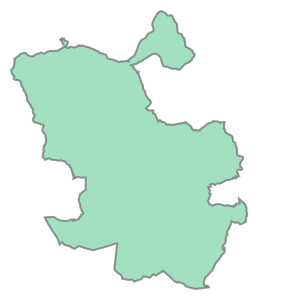

In [5]:
bounds_geom = bounds_gpd.union_all()
bounds_geom

If the geometries are complex, then the OSM data request may fail due to URL length limitations (because each coordinate has to be passed in the URL). To avoid this, you can use the `convex_hull` or else the `simplify` method to reduce the number of points in the geometry.


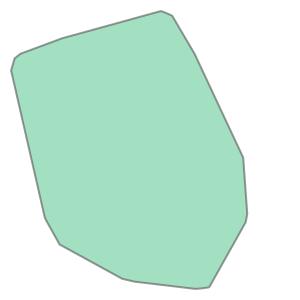

In [6]:
bounds_geom_simpl = bounds_geom.convex_hull
bounds_geom_simpl

It is best practise to buffer the geometry by an amount matching the farthest distance used for centrality or accessibility calculations, which prevents edge roll-off effects.


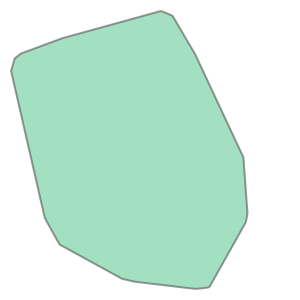

In [7]:
bounds_geom_buff = bounds_geom_simpl.buffer(100)
bounds_geom_buff

The `shapely` Polygon can now be used as before to download and prepare an OSM graph.


In [8]:
# simplification turned off for this example
G = io.osm_graph_from_poly(bounds_geom_buff, poly_crs_code=epsg_code, simplify=False)
print(G)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
INFO:cityseer.tools.graphs:Removing filler nodes.


MultiGraph with 216947 nodes and 296530 edges


INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 296530/296530 [00:04<00:00, 67076.99it/s]


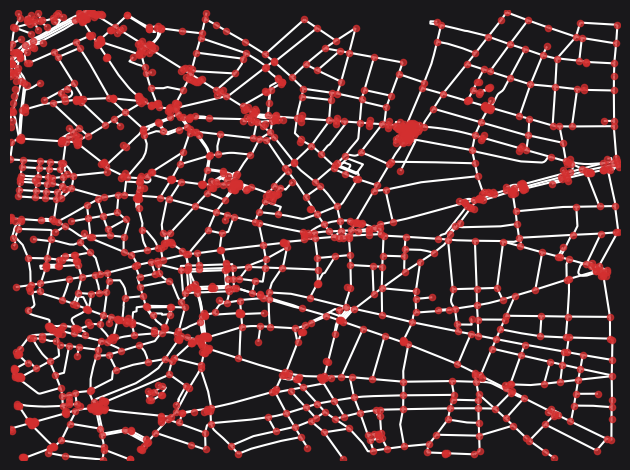

In [11]:
plot.plot_nx(
    G, plot_geoms=True, x_lim=(439500, 439500 + 1500), y_lim=(4473500, 4473500 + 1500)
)